In [1]:
import pandas as pd
import numpy as np
import csv
import matplotlib.pyplot as plt

from datetime import datetime, timedelta

from os import listdir, walk
from os.path import isfile, join

In [2]:
def calc_sec(time):
    hms = time.split(':')
    hms = [float(x) for x in hms]
    sec = hms[2] + hms[1]*60 + hms[0]*3600
    sec = round(sec,3)
    return sec

In [3]:
def calc_ts(sec):
    ts = ''
    hr = int(sec/3600)
    mn = int((sec - (hr*3600))/60)
    sc = sec - (hr*3600) - (mn*60)
    sc = round(sc,3)
    ts += str(hr) + ':' + str(mn) + ':' + str(sc)
    # print(ts)
    return ts

In [4]:
mypath = 'DDC_Data/'
nectec_dir = 'NECTEC_Data/'

In [5]:
def load_sensor_data(subject_id):
    sid_dir = mypath + subject_id
    sid_files = [f for f in listdir(sid_dir) if f[5:9]=='data']

    filepath = sid_dir + '/' + sid_files[0]

    df_n = pd.read_csv(filepath, header=2, names=['sensor_id','timestamp','count','x','y','z',
                                                  'gyro_x','gyro_y','gyro_z','mag_x','mag_y','mag_z','mark'])

    df_n['timestamp'] = df_n['timestamp'].apply(lambda x: (datetime.utcfromtimestamp(x/1000) + timedelta(hours=7)).strftime('%Y-%m-%d %H:%M:%S.%f'))

    xyz_cols = ['x','y','z']
    g = 9800
    for c in xyz_cols:
        df_n[c] = df_n[c].apply(lambda x: x/g)

    cols = ['timestamp','x','y','z']
    df = df_n[cols].dropna()
    df = df.reset_index(drop=True)

    df.to_csv(nectec_dir + subject_id + '-nectec.csv')
    
    return df

In [6]:
def load_timer(subject_id):
    sid_dir = mypath + subject_id
    sid_files = [f for f in listdir(sid_dir) if f[5:11]=='iphone']
    
    timer_path = sid_dir + '/' + sid_files[0]
    
    df_timer = pd.read_csv(timer_path, header=None, names=['sid','raw_label', 'timestamp', 'duration','label'])

    filtered_timer = [i for i in df_timer['sid'] if i==int(subject_id)]

    timer_filt = df_timer[df_timer['sid'].isin(filtered_timer)]
    timer_filt = timer_filt.reset_index(drop=True)

    timer_arr = []

    for i in range(len(timer_filt)):
        if(timer_filt.loc[i]['raw_label']=='upstairs' or 
          timer_filt.loc[i]['raw_label']=='downstairs'):
            timer_arr.append('walk')
        else:
            timer_arr.append(timer_filt.loc[i]['raw_label'])

    timer_filt['label'] = pd.Series(timer_arr)

    timer_filt.to_csv(nectec_dir + subject_id + '-timer.csv')

    return timer_filt

In [7]:
all_subjects = [str(i) for i in range(4001,4002)]

print(all_subjects)

['4001']


In [9]:
for sid in all_subjects:
    print(sid)
    df = load_sensor_data(sid)
    timer_filt = load_timer(sid)

4001


In [10]:
time_prd = []

for i in range(len(timer_filt)):
    tm = calc_sec(timer_filt.loc[i]['timestamp'].split(' ')[1])
    dur = calc_sec(timer_filt.loc[i]['duration'])
    
    time_prd.append([tm, tm+dur])

In [11]:
label_list = []

for i in range(len(df)):
    cnt = 0
    for j in range(len(time_prd)):
        tm = calc_sec(df.loc[i]['timestamp'].split(' ')[1])
        if(tm>=time_prd[j][0] and tm<=time_prd[j][1]):
            label_list.append(timer_filt['label'])
            cnt = 1
        
#         print(tm, time_prd[j][0], time_prd[j][1])
    
    if(cnt==0):
        label_list.append('NaN')

df['label'] = pd.Series(label_list)

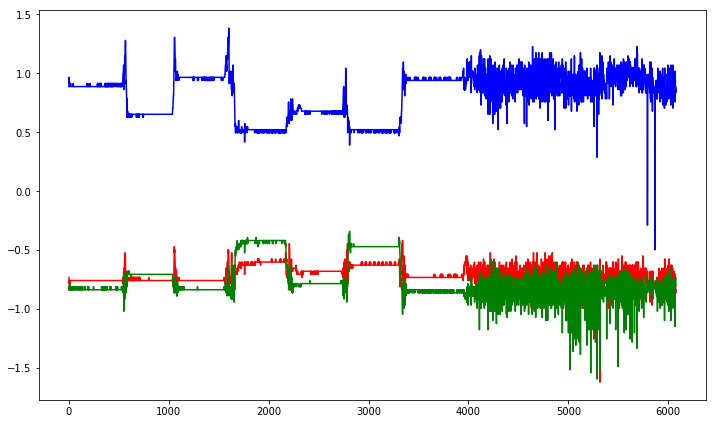

In [14]:
f, ax = plt.subplots(nrows=1, ncols=1, figsize=(10,6))
f.tight_layout()
ax.plot(df['x'], color='r')
ax.plot(df['y'], color='g')
ax.plot(df['z'], color='b')

plt.show()